# Activity recognition with accelerometer data using a recurrent neural network
### By: Matthew Fernandez

Recurrent neurons have state and are known to be useful with sequential data.
The purpose of this notebook is to learn to use recurrent layers in Keras and
to see whether a recurrent network can outperform a convolutional network.

In [29]:
import numpy as np
from scipy.signal import find_peaks, periodogram
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Embedding, SimpleRNN, Dense, Flatten
from keras.models import Sequential
# avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
# optimal hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [30]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

In [31]:
np.random.seed(0)

### Read data and perform basic preprocessing

In [32]:
# Load data for a single user.  Users are numbered 1-15.
infile = 'YOURPATHERE/activity_data.csv'
df = pd.read_csv(infile, index_col=0, header=None)

df.columns = ['x', 'y', 'z', 'activity']
df = df[df['activity'] != 0]
df['activity'] = df['activity'] - 1
activity_names = ['desk', 'mixed', 'standing', 'walking', 'stairs', 'talking/walking', 'talking/standing']

### Initial exploration

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 122200 entries, 0.0 to 122200.0
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   x         122200 non-null  int64
 1   y         122200 non-null  int64
 2   z         122200 non-null  int64
 3   activity  122200 non-null  int64
dtypes: int64(4)
memory usage: 4.7 MB


In [34]:
df.describe()

,x,y,z,activity
count,122200.000000,122200.000000,122200.000000,122200.000000
mean,2053.151088,2377.315164,2024.087070,2.904992
std,51.148136,56.854804,46.609623,2.313771
min,1132.000000,1649.000000,878.000000,0.000000
25%,2019.000000,2369.000000,2007.000000,0.000000
50%,2053.000000,2380.000000,2025.000000,3.000000
75%,2081.000000,2387.000000,2034.000000,6.000000
max,2723.000000,3046.000000,2954.000000,6.000000


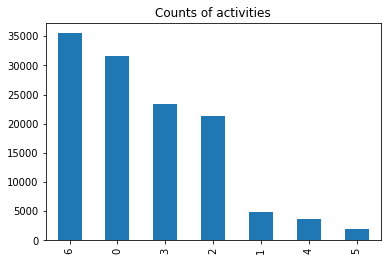

In [35]:
df['activity'].value_counts().plot.bar()
plt.title('Counts of activities');

### Data preparation

In [36]:
def create_segments(X, window_size, shift):
    """ Return a list of NumPy arrays, each a segment.
    
    X is a numpy array with shape (number of time steps, number of variables)
    window_size defines the size of the segments
    shift is the number of time steps to shift the window
    
    The output is a NumPy array with shape (k, window_size, n)
    """

    # compute number of segments in X
    # X.shape[0]/shift gives total number of window positions
    num_segments = np.floor(X.shape[0]/shift) - np.ceil(window_size/shift)
    num_segments = int(num_segments)
    
    # create the segments
    segments = np.zeros((num_segments, window_size, X.shape[1]))
    for i in np.arange(num_segments):
        segments[i, :, :] = X[(i*shift):(i*shift + window_size), :]
        
    return segments

In [37]:
def clean_and_label(segments):
    """ From the given segments, create a new array of the clean segments.
    Return the clean segments, with activity values removed, 
    and an activity label for each.
    """

    # compute number of single class ("clean") segments
    n = segments.shape[0]
    num_clean = 0
    for i in range(n):
        segment_classes = segments[i,:,3]
        if segment_classes.min() == segment_classes.max():
            num_clean += 1
    
    print('fraction of segments with a single class: {:.3f}'.format(num_clean/n))
    
    # create clean segments, and create training labels
    segs = np.zeros((num_clean, segments.shape[1], segments.shape[2]-1))
    y = np.full(num_clean, 0)
    idx = 0
    for i in range(n):
        segment_classes = segments[i,:,3]
        if segment_classes.min() == segment_classes.max():
            segs[idx,:,:] = segments[i,:,:3]
            y[idx] = segment_classes[0]
            idx += 1
            
    return segs, y

#### Create raw segments from data

Each segment can have multiple class labels associated with it.

In [38]:
window_size = 100
shift = 10
segments = create_segments(df.values, window_size, shift)
X, y = clean_and_label(segments)

fraction of segments with a single class: 0.994


In [39]:
print(X.shape)
print(y.shape)

(12137, 100, 3)
(12137,)


Plot a random clean segment.

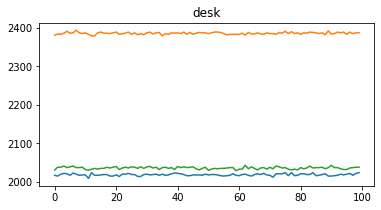

In [40]:
plt.figure(figsize=(6,3))
i = np.random.choice(X.shape[0])
plt.plot(X[i])
plt.title(activity_names[y[i]]);

### Prepare data for machine learning

Perform any further preprocessing, then do a train/test split.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8495, 100, 3) (8495,)
(3642, 100, 3) (3642,)


Check the target values.

In [43]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6]), array([2190,  333, 1443, 1621,  263,  131, 2514]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 955,  139,  670,  700,  102,   51, 1025]))


### Machine learning

The goal is to predict the activity of a training example.  This is a multi-class classification problem.

In [44]:
# to get baseline accuracy, always predict the most common activity
counts = df['activity'].value_counts()/df.shape[0]
print('baseline accuracy: {:0.4f}'.format(counts[0]))

baseline accuracy: 0.2581


This is to help ensure that a standard data set is being used.

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train.sum(), X_test.sum())

(8495, 100, 3) (8495,)
(3642, 100, 3) (3642,)
5483020712.0 2350871716.0


#### Recurrent models
Rearranging the dataset helped to push the data though the neural network similar to how chollet does, although the approaches are different being that we are predicting the activity not a word structure. That being said, let us rearrange the training subsets into two dimensions. 

In [46]:
# delete any old models
K.clear_session()
# rearrange X_train & X_test from 3D into 2D
X_train2 = X_train.reshape(8495, 300)
X_test2 = X_test.reshape(3642, 300)

We would like to now create a baseline RNN model and structure its architecture similar to how Chollet recommends in chapter 6.2.1. We will stack 3 SimpleRNN layers, let us do so now.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 300, 32)           2080      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 7)                 67207     
                                                                 
Total params: 393,447
Trainable params: 393,447
Non-trai

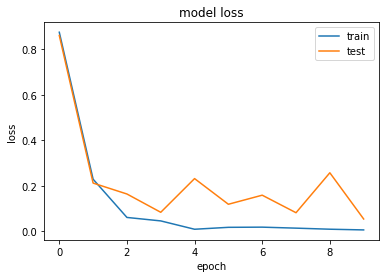

In [47]:
model = Sequential()
model.add(Embedding(10000,32, input_length=(300)))

# stack several recurrent layers one after another like Chollet suggests
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(7, activation='softmax')) # multi-classification

model.summary()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train2, y_train, epochs=10, batch_size=128, validation_split=.3)

plot_metric(history)

Above, we can see that our baseline model performs very well as opposed to guessing the most common activity for every instance. We now obtain a validation accuracy of 95% before overfitting after the 4th epoch, this is fantastic. It would be interesting to see how a Bidirectional layer affects our baseline model. We will also add an LSTM layer which is ideal for series data. Let us do so now below. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         49664     
 l)                                                              
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 300, 32)           5152      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 flatten_1 (Flatten)         (None, 9600)              0         
                                                      

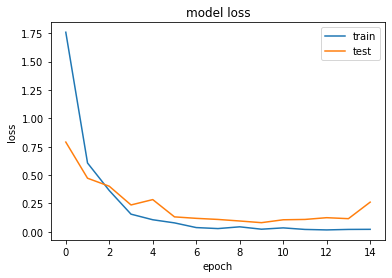

In [48]:
model = Sequential()
model.add(Embedding(10000,32, input_length=(300)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
# want to read the segments back to front not just front to back.

# stack several recurrent layers one after the other like Chollet suggests
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(7, activation='softmax')) # multi-classification

model.summary()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train2, y_train, epochs=15, batch_size=128, validation_split=.3)

plot_metric(history)

As we can see this model performs 1% better than the baseline at 97% validation accuracy just before we begin to overfit at the 10th epoch. The only difference between the two models is that we are now training the model with the segments being trained back-to-front and also front-to-back.  Let us now avoid overfitting with early stopping in our model as well as speed up the computational time by turning off 10% of neurons that do not contribute much.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 128)         49664     
 nal)                                                            
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 300, 32)           5152      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 flatten_2 (Flatten)         (None, 9600)              0         
                                                      

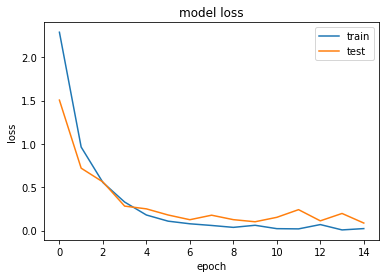

In [49]:
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

model = Sequential()
model.add(Embedding(10000,32, input_length=(300)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
# want to read the segments back to front not just front to back.

# stack several recurrent layers one after the other like Chollet suggests
model.add(SimpleRNN(32, return_sequences=True, dropout=0.1))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Flatten())
model.add(Dense(7, activation='softmax')) # multi-classification

model.summary()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train2, y_train, epochs=15, batch_size=128, validation_split=.3)

plot_metric(history)

It seems that dropping off 10% of the neurons that are not contributing much slightly helped improve our models' validation accuracy by 1% giving us 97% at the end of the day.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 32)           320000    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 300, 32)           2080      
                                                                 
 flatten_3 (Flatten)         (None, 9600)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 67207     
                                                                 
Total params: 389,287
Trainable params: 389,287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
93/93 [==============================] - 15s 143ms/step - loss: 0.6151 - accuracy: 0.7743 - val_loss: 0.3884 - val_accuracy: 0.8596
Epoch 2/15
93/93 [===================

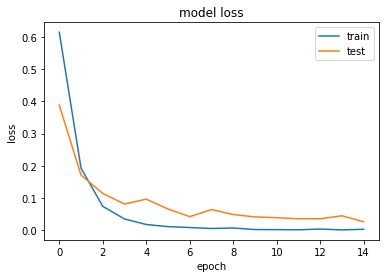

In [50]:
early_stopping = EarlyStopping(patience=5, monitor='val_loss') 

model = Sequential()
model.add(Embedding(10000,32, input_length=(300)))
model.add(SimpleRNN(32, return_sequences=True, dropout=0.1)) # turn off 10% of weak neurons
model.add(Flatten())
model.add(Dense(7, activation='softmax')) # multi-classification

model.summary()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train2, y_train, epochs=15, batch_size=64, callbacks=[early_stopping] ,validation_split=.3)

plot_metric(history)

This by far is the best performing model, with a validation accuracy of 99%, we implemented early stopping so we can conclude that we have avoided overfitting with this model. It is surprising to see that a simpler model without stacking simpleRNN layers as Chollet suggests, and without Bidirectional or LTSM layers outperforms all previous models. This model has 389,287 parameters so is not that small. 

In [51]:
model.evaluate(X_test2, y_test)

114/114 [==============================] - 2s 19ms/step - loss: 0.0373 - accuracy: 0.9912


[0.0373268760740757, 0.9912136197090149]

### Conclusion
Our basic RNN model consisted of 3 stacked simpleRNN layers like Chollet suggests, as well as using relu for an activation function, and at the end of the day performed very well with 96% validation accuracy. The True test accuracy shows that this model is indeed amazing, and not a fluke with 99% accuracy and less than 3% loss. As we progressed to push this model to its optimal performance we found that early stopping to avoid overfitting, turning off 10% of the neurons which did not help us much at predicting the activity which helped us achieve our best model. That model performed at 98% validation accuracy, much better than the baseline model. It is important to note that we had to reshape the training subsets to properly fit into an embedding layer which at first sounded like dropping a channel would be detrimental, however, we cannot argue that this model performs exceptionally. 